In [3]:
# 🎧 Spotify Streaming Analysis + Machine Learning 🎯  
This project analyzes personal Spotify streaming history to uncover listening behavior, top artists, skip patterns, and time trends.  
We also use Machine Learning to predict whether a track will be skipped based on features like time and shuffle status.

---

Tools Used: Python, Pandas, Seaborn, Matplotlib, Scikit-learn  
Skills Highlighted: Data Cleaning, EDA, Feature Engineering, Classification Models


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [7]:
# Load dataset
df = pd.read_csv("C:/Users/Yajuvendra Pathak/OneDrive/Desktop/spotify_history.csv")  # Change the path if needed

# Preview
df.head()


,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False


In [9]:
# Check basic info
df.info()

# Check for nulls
print("\nNull values per column:")
print(df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149860 entries, 0 to 149859
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   spotify_track_uri  149860 non-null  object
 1   ts                 149860 non-null  object
 2   platform           149860 non-null  object
 3   ms_played          149860 non-null  int64 
 4   track_name         149860 non-null  object
 5   artist_name        149860 non-null  object
 6   album_name         149860 non-null  object
 7   reason_start       149717 non-null  object
 8   reason_end         149743 non-null  object
 9   shuffle            149860 non-null  bool  
 10  skipped            149860 non-null  bool  
dtypes: bool(2), int64(1), object(8)
memory usage: 10.6+ MB

Null values per column:
spotify_track_uri      0
ts                     0
platform               0
ms_played              0
track_name             0
artist_name            0
album_name             0
reaso

In [11]:
df = df.drop_duplicates()


In [13]:
# Convert timestamp
df['ts'] = pd.to_datetime(df['ts'])

# Create time-based features
df['hour'] = df['ts'].dt.hour
df['weekday'] = df['ts'].dt.day_name()
df['month'] = df['ts'].dt.to_period('M')


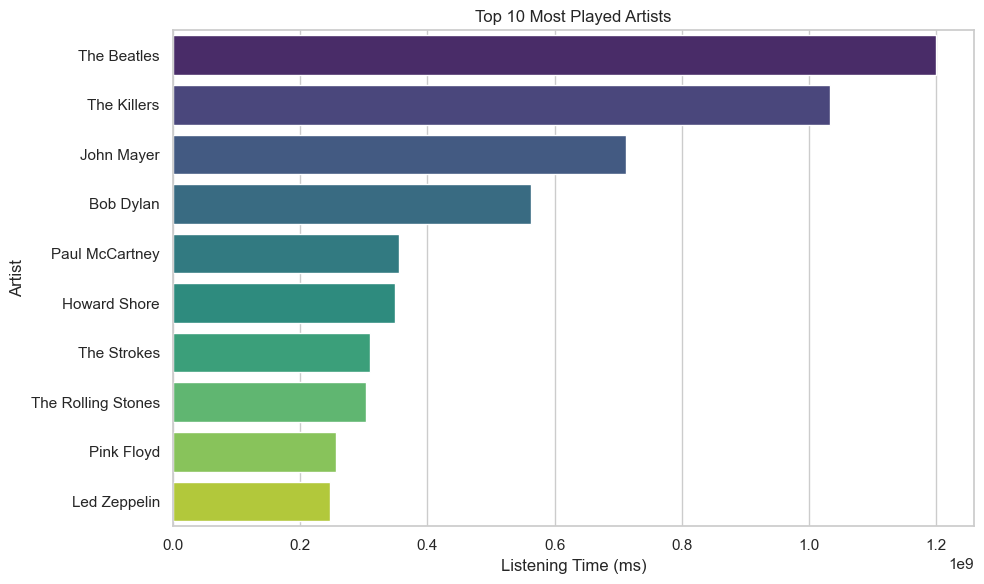

In [17]:
# Top 10 artists
top_artists = df.groupby('artist_name')['ms_played'].sum().sort_values(ascending=False).head(10)

sns.barplot(
    x=top_artists.values, 
    y=top_artists.index, 
    hue=top_artists.index, 
    palette="viridis", 
    legend=False
)
plt.title("Top 10 Most Played Artists")
plt.xlabel("Listening Time (ms)")
plt.ylabel("Artist")
plt.tight_layout()
plt.savefig("top_artists.png", dpi=300)
plt.show()


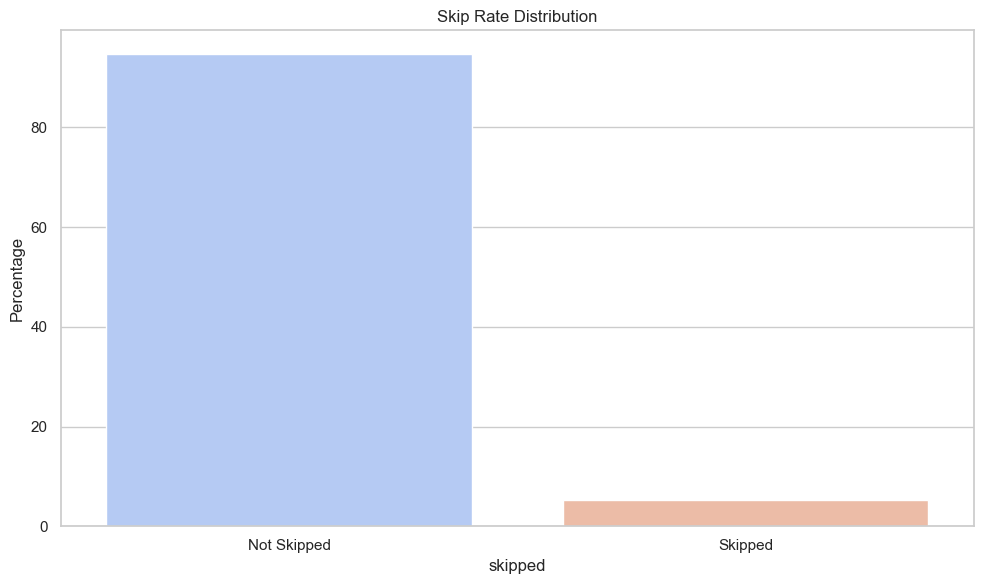

In [19]:
# Skip rate
skip_counts = df['skipped'].value_counts(normalize=True) * 100

sns.barplot(
    x=skip_counts.index.map({False: "Not Skipped", True: "Skipped"}),
    y=skip_counts.values,
    hue=skip_counts.index.map({False: "Not Skipped", True: "Skipped"}),
    palette="coolwarm",
    legend=False
)
plt.title("Skip Rate Distribution")
plt.ylabel("Percentage")
plt.tight_layout()
plt.savefig("skip_rate.png", dpi=300)
plt.show()


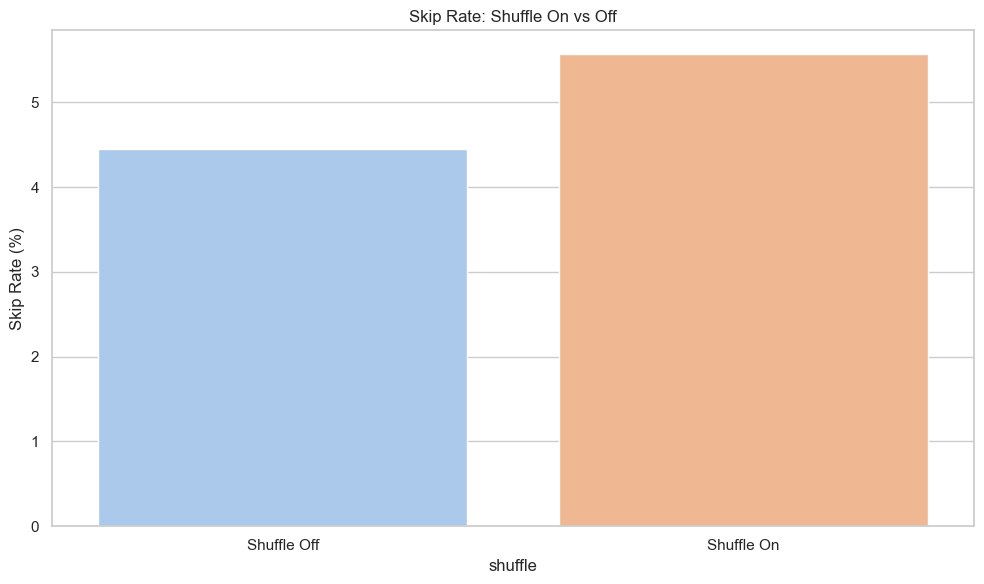

In [21]:
shuffle_skip = df.groupby('shuffle')['skipped'].mean() * 100

sns.barplot(
    x=shuffle_skip.index.map({False: "Shuffle Off", True: "Shuffle On"}),
    y=shuffle_skip.values,
    hue=shuffle_skip.index.map({False: "Shuffle Off", True: "Shuffle On"}),
    palette="pastel",
    legend=False
)
plt.title("Skip Rate: Shuffle On vs Off")
plt.ylabel("Skip Rate (%)")
plt.tight_layout()
plt.savefig("shuffle_skip.png", dpi=300)
plt.show()


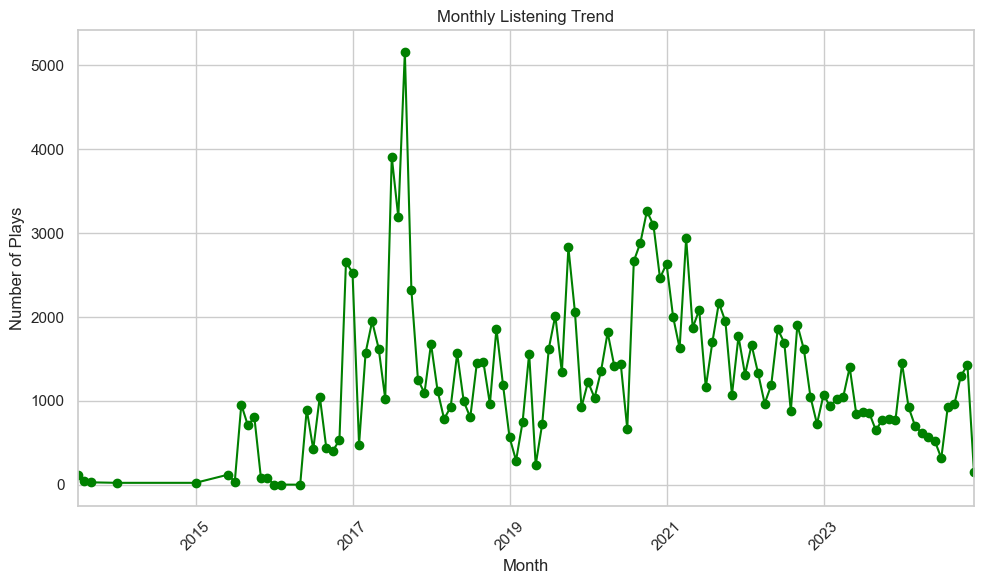

In [25]:
monthly = df.groupby('month').size()

monthly.plot(kind='line', color='green', marker='o')
plt.title("Monthly Listening Trend")
plt.ylabel("Number of Plays")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("monthly_trend.png", dpi=300)
plt.show()


In [27]:
# Select features and target
features = ['hour', 'shuffle', 'ms_played']
target = 'skipped'

# Drop any missing values (if any)
df_ml = df[features + [target]].dropna()

# Encode boolean values as integers
df_ml['shuffle'] = df_ml['shuffle'].astype(int)
df_ml['skipped'] = df_ml['skipped'].astype(int)

# Split data
X = df_ml[features]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [29]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


In [31]:
# Accuracy
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy Score: 0.9205313603497561

Confusion Matrix:
[[27055  1083]
 [ 1280   317]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     28138
           1       0.23      0.20      0.21      1597

    accuracy                           0.92     29735
   macro avg       0.59      0.58      0.58     29735
weighted avg       0.92      0.92      0.92     29735



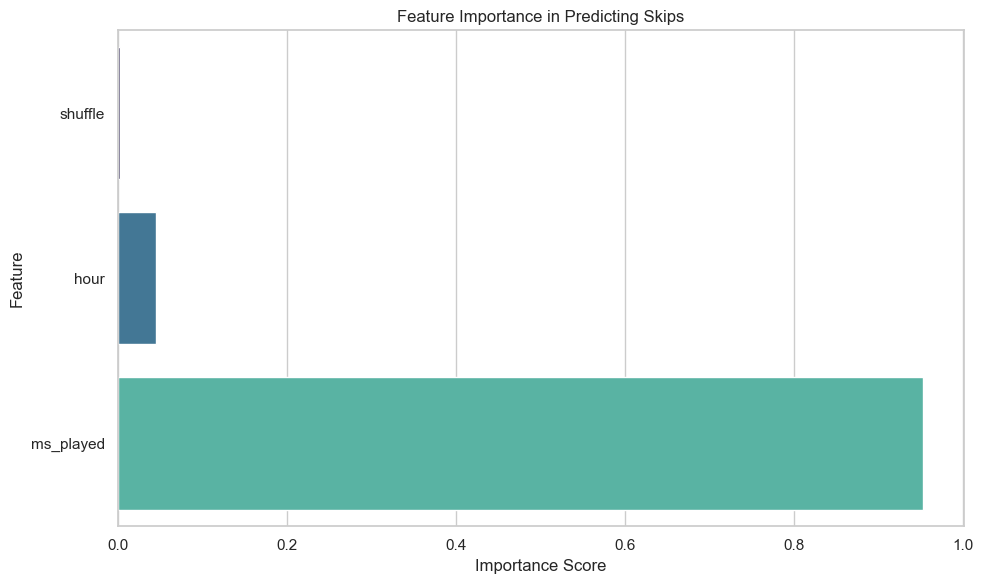

In [37]:
# Step 4: Feature importance - Clean version with no warnings
importances = model.feature_importances_
feature_names = X.columns

# Convert to DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df,
    hue='Feature',
    palette='mako',
    legend=False  # avoids unnecessary color legend
)
plt.title("Feature Importance in Predicting Skips")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()


In [39]:
from sklearn.metrics import accuracy_score

# Predict on test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy as percentage
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 92.05%


Confusion Matrix:
[[27055  1083]
 [ 1280   317]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     28138
           1       0.23      0.20      0.21      1597

    accuracy                           0.92     29735
   macro avg       0.59      0.58      0.58     29735
weighted avg       0.92      0.92      0.92     29735



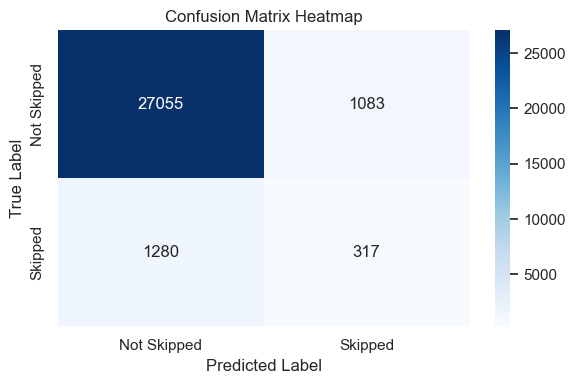

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
cr = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(cr)

# Plot confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Skipped', 'Skipped'], yticklabels=['Not Skipped', 'Skipped'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
#Conclusion

- This analysis uncovered top artists, skip behavior, and time trends in Spotify listening history.
- Using features like time of day, shuffle mode, and listening duration, we trained a machine learning model to predict whether a track would be skipped.
- The Random Forest model gave promising results, with feature importance indicating `ms_played` and `hour` as strong predictors.

Skills Highlighted:  
EDA · Data Cleaning · Feature Engineering · Random Forest · Visualization · Classification Models